### 0001137778 Davide Cremonini davide.cremonini8@studio.unibo.it
### 0001146107 Gabriele Nanni gabriele.nanni4@studio.unibo.it

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

# Importing Dataset and Functions


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from math import log10, sqrt

# Denoising the Images


As specified by the assignments, each one of the scene images is affecte by heavy noise. From what is visible, we can assume there are two main noise component present:


*   Gaussian Noise, sparse and distributed all over the image
*   Impulse Noise, visible as unexpected peaks in colors inside the image

The following paragraph describes the techniques and filter deployed in order to counter these sources of noise.
During the instance detection procedures both gray scale and RGB scale versions of the images will be used so the following functions take into consideration appropriate strategies to apply denoising on both types of images.




###Clahe technique
 Here we have a function which applies the **CLAHE** (Contrast Limited Adaptive Histogram Equalization) process to images, which is an effective and well known technique to enhance contrast in images. CLAHE is usually applied to either single-level images (like gray scale) or to the Luminance component of colored images, previously converted into the LAB format, and utilizes bilinear interpolation on neighbouring tiles in the image.
 The function presented below can be effectedly used on both GRAY and RGB images by setting the appropriate parameter.

In [ ]:
def clahe_img(img, gray=True):
  clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
  if gray:
    cl1=clahe.apply(img)
  else:
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L,A,B = cv2.split(img_LAB)
    clL = clahe.apply(L)
    cl_LAB = cv2.merge((clL,A,B))
    cl1 = cv2.cvtColor(cl_LAB, cv2.COLOR_LAB2RGB)
  return cl1

### Denoising Function
As shown in the following function the denoising strategy for both gray-scale and RGB versions of the images are mostly identical with the addition of minor tweaks to properly enhance contrast on both types of images.
The main denosing strategy deployed consists int three main filters:



*   Median Filter with kernel size 5, this filter is principally used to counter impulse noise
*   Gaussian Filter with kernel size 5 and sigma=1, is used to smooth the image and counter gaussian noise
*   Non-Local-Means filter with a patch size of 7 and a maximum patch distance of 21. This filter is the main denoising component of the pipeline and is used to furter remove Gaussian noise while preserving the edges. Two different implementations were used: one for gray-scale and one for colored images, in both cases the general filter strength was set to 10, the same can be said for the filter strength along the color axis.

Gray-scale images were enhanced in contrast by using the CLAHE technique described above.
Colored images were instead enhanced by increasing contrast of the image by 1.1.



In [ ]:
def denoise_img(img, gray=False, med_kern=5, gaus_kern=5, nl_h=10, nl_hcol=10, nl_tw=7, nl_sw=21):
  if not gray:
    img_filtered = cv2.medianBlur(img,med_kern)
    img_filtered = cv2.GaussianBlur(img_filtered, (gaus_kern,gaus_kern), 1, 1)
    img_filtered = cv2.fastNlMeansDenoisingColored(src=img_filtered, dst=None, h=nl_h, hColor=nl_hcol ,templateWindowSize=nl_tw, searchWindowSize=nl_sw)
    img_filtered = cv2.addWeighted(img_filtered, 1.1, np.zeros(img_filtered.shape, img_filtered.dtype), 0, 1)
  else:
    img_gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_filtered = cv2.medianBlur(img_gray,med_kern)
    img_filtered = cv2.GaussianBlur(img_filtered,  (gaus_kern,gaus_kern), 1, 1)
    img_filtered = cv2.fastNlMeansDenoising(src=img_filtered, dst=None, h=nl_h, templateWindowSize=nl_tw, searchWindowSize=nl_sw)
    img_filtered = clahe_img(img_filtered)
  return img_filtered

Here we apply the denoising to all scene images and create two separate lists, one for the gray versions and one for the colored ones.

In [ ]:
partial_url='dataset/scenes/scene'

#original_imgs=[]
imgs = []
imgs_gray=[]

for i in range(1,13):
  img = cv2.imread(partial_url+str(i)+'.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  clean_img = denoise_img(img, gray=False, med_kern=5, gaus_kern=5, nl_h=12, nl_hcol=12, nl_tw=7, nl_sw=21)
  clean_img_gray = denoise_img(img, gray=True, med_kern=5, gaus_kern=5, nl_h=12, nl_tw=7, nl_sw=21)
  imgs.append(clean_img)
  imgs_gray.append(clean_img_gray)

Two separate lists are also created for reference images in both color scales, in this case no denoising is needed.

In [ ]:
partial_url='dataset/models/ref'
refs=[]
refs_gray=[]
for i in range(1,28):
  ref = cv2.imread(partial_url+str(i)+'.png')
  ref_rgb = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB) #not necessary
  refs.append(ref_rgb)
  refs_g=(cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY))
  refs_gray.append(cv2.normalize(refs_g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))

# Instance Detection

## The approach

In this notebook we decided to provide an approach that was both robust and adaptive. To achieve these objectives the proposed method combines two effective techniques to perform object detection: Keypoint Matching and Template Matching.
Keypoint matching is used as a candidate selector for instances that may be present in the image. The SIFT feature detector and descriptor is extremely effective at capturing significant features inside images but despite its accuracy its main blindspot is the fact that can only work on grayscale images which may result ineffective when it comes to telling apart two boxes with similar features but different colours. From this comes our decision to pair it with Template matching as a validator for the found instances.
So the general strategy describes below will consist in selecting in each image the best possible instance candidates on gray-scale scene images and validating true matches by comparing the projected reference image in the corresponding patch on the colored scene image.




##Definition of useful functions

### _getSliceFromPoly_

This is a utility function used to obtain the extremes that bound a polygonal line, meaning the rectangular patch that thightly encloses the figure.
Given a list of points it will return the minimal and maximal coordinates to encompass the polyline.



In [ ]:
def getSliceFromPoly(polyline):
  minX=polyline[0][0][0]
  maxX=polyline[0][0][0]
  minY=polyline[0][0][1]
  maxY=polyline[0][0][1]
  for p in polyline:
    if p[0][0]<minX:
      minX=p[0][0]
    if p[0][0]>maxX:
      maxX=p[0][0]
    if p[0][1]<minY:
      minY=p[0][1]
    if p[0][1]>maxY:
      maxY=p[0][1]
  results = [int(minX), int(maxX), int(minY), int(maxY)]
  return [max(num, 0) for num in results]

### _detect_keypoints_

Utility function which, given a detector and a list of images, returns two lists, one containing all keypoints contained in each image and the other containing a all descriptors for said keypoints.

In [ ]:
def detect_keypoints(detector, images):
  kp_imgs=[0 for i in range(len(images))]
  des_imgs=[0 for i in range(len(images))]
  for i in range(len(images)):
    kp_imgs[i], des_imgs[i] = detector.detectAndCompute(images[i], None)
  return kp_imgs, des_imgs

### _find_matches_

Utility function which given a matcher, the number of images and references, the lists of descriptors for both images and references this function returns an array containing, for each reference a list of matches between its descriptors and the scene images's descriptors. Each match containt the two closest matches for each descriptor.

In [ ]:
def find_matches(matcher, n_imgs, n_refs, images_des, references_des):
  matches=np.empty((n_refs,1)).tolist()
  for j in range(n_refs):
    matches[j]=[]
    cv2.setRNGSeed(629)
    matches[j] = matcher.knnMatch(references_des[j],images_des,k=2)
  return matches

### _filter_matches_

Utility function that Given an 2D array containing lists of couples of matches (m,n), this function filters those matches by keeping only those where m.distance<dist_ratio*n.distance, according to Lowe's ratio of distance criterion.

In [ ]:
def filter_matches(matches, dist_ratio, n_imgs, n_refs):
    good=np.empty((n_refs,1)).tolist()
    for j in range(n_refs):
      good[j] = []
      for m1,n1 in matches[j]:
        if m1.distance < dist_ratio * n1.distance:
          good[j].append(m1)
    return good

### _delete_kp_in_area_

Utility function that removes given two lists: one of keypoints and the other of their descriptors, and a patch expressed by an origin point and height and width, deletes from the lists all keypoints contained in the patch and their respective descriptors.

In [ ]:
def delete_kp_in_area(kps, des, origin, h, w):
  new_kps = []
  new_des = []
  for i in range(len(kps)):
    if kps[i].pt[0]>origin[0] and kps[i].pt[0]<origin[0]+w and kps[i].pt[1]>origin[1] and kps[i].pt[1]<origin[1]+h:
      continue
    else:
      new_kps.append(kps[i])
      new_des.append(des[i])
  return new_kps, new_des

### _get_instances_

This is the main utility function which is charged with the responsability of detecting all instances inside one image and delivering them to the main function and as such it includes most of the logic for the candidate selection and validation process.
Both processes are handled through a thresholding procedure and in both cases the threshold takes possesses a fixed component and a window component, which will help making the process more dynamic. The algorithm works under two main assumptions:


*   The number of keypoints in each instance is linearly related to the density of keypoints inside the image (the ratio between the total number of kypoints and the area of the image) so, the higher the density of points in the image is, the higher we expect the number of keypoints for each instance to be.
*   Correlation between template and the image candidate patch grows linearly with respect to the ratio between the area of the patch and the area of the whole image. We expect higher template matching correlation for those instances that occupy a larger patch of the image as they are assumed to have higher resolution.

Given the matcher, a single coloured scene image, all coloured reference images, lists for keypoints and descriptors for both scene and references and tunable thresholding parameters the function iteratively computes matches between each reference descriptors and the images, filtereing them each time according to Lowe's criterion, then selects as a candidate the reference which has the highest amount of matches. In case the number of matches is above the previously described threshold the candidate's keypoints are used to compute a cropped homography of the reference in question which is the used to perform the template matching on the local patch of the image which is suspected of containing the reference. In case the template matches, the instance is added to the list of found instances and the search restarts after removing all keypoints loacated inside the patch where the instance was found and computing new matches. At this point a new reference candidate may be selected dependingo on the number of remaining matches.
If the homography is impossible to compute, or transforms the reference witout respecting its dimensional ratio or if the template matching is below the desired threshold a new candidate will be chosen with the next highest number of matches without removing any keypoints from the image.

Once the search loop is over, the function will return a list of dictionaries, each one containing details on one of the instances found inside the image.

The function needs to be tuned by finding the right values for the fixed and variable thresholds for both keypoints and template matching.






In [ ]:
#Given a scene image with its keypoints and a list containing the keyponts for each reference, this function returns a dictionary containing all instances of the references present in the image
def get_instances(matcher, img, references, kp_img, kp_refs, des_img, des_refs, fix_kp_thresh, wind_kp_thresh, fix_temp_thresh, wind_temp_thresh, shift=0):

  instances=[] #List of instances that are found in the image
  kp = np.array(kp_img) #Working copy of the keypoints inside the image, as some of them will be removed by the function
  des = np.array(des_img) #Working copy of the image keypoint descriptors, as some of them will be removed by the function
  img_w, img_h, img_c = img.shape #Shapes of the input image
  density = len(kp)/(img_w*img_h) #Density of keypoints inside the image, will be used to determine the dynamic threshold for number of correct matches
  thresh = fix_kp_thresh + density*wind_kp_thresh #Dynamic threshold for number of correct matches
  n_refs = len(references) #Number of references


  matches=find_matches(matcher, 1, n_refs, des, des_refs) #Find matches between each reference and the image
  good=filter_matches(matches, 0.7, 1, n_refs) #Filter matches using Lowe's ratio of distances criterion
  good_num = [len(good[i]) for i in range(len(good))] #Define an array containing the number of good matches for each reference
  best_index = np.argmax(np.array(good_num)) #Select the reference (by index) where most matches are found
  attempt=1

  while good_num[best_index]>thresh: #The function will look for potential instances until the number of good matches of a potential candidate falls below a certain dynamic threshold
    h_ref, w_ref, c_ref = references[best_index].shape #Obtain shape data from the reference in question
    src_pts = np.float32([ kp_refs[best_index][m.queryIdx].pt for m in good[best_index] ]).reshape(-1,1,2) #Select the query side of the match from the list of good matches
    dst_pts = np.float32([ kp[m.trainIdx].pt for m in good[best_index] ]).reshape(-1,1,2) #Select the train side of the match from the list of good matches
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) #Compute the Homography from planar perspective of the reference image to the projective perspective of the scene image

    if M is None: #In case no Homography matrix was found, the match is considered wrong by default
      attempt+=1 #A new attempt will be made
      best_index = np.argsort(good_num, axis=0)[-attempt] #The next maximum value is choses as potential match candidate
      continue

    result = cv2.warpPerspective(references[best_index], M, (img.shape[1], img.shape[0])) #Transform the reference according to the found homography
    pts = np.float32([ [0,0],[0,h_ref],[w_ref,h_ref],[w_ref,0] ]).reshape(-1,1,2) #Define a rectangle with the same shape of the reference
    dst = cv2.perspectiveTransform(pts,M) #Transform the rectangle according to the found homography


    slices = getSliceFromPoly(dst) #Obtain slicing indexes from the projected rectangle

    crop_ref = result[slices[2]:slices[3]+1, slices[0]:slices[1]+1] #Slice a crop from the projected reference image
    crop_img = img[slices[2]:slices[3]+1, slices[0]:slices[1]+1] #Slice a crop of the found instance in the scene image

    h_crop, w_crop, c_crop = crop_ref.shape #Obtain shape data from the crop

    if h_crop==0 or w_crop==0: #In case  the crop has a 0 dimension, the match is considered wrong by default
      attempt+=1 #A new attempt will be made
      best_index = np.argsort(good_num, axis=0)[-attempt] #The next maximum value is choses as potential match candidate
      continue
    else:
      crop_ratio = h_crop/w_crop #Ratio of dimensions for the projected reference
      ref_ratio = h_ref/w_ref #Ratio of dimensions for the reference


    if h_crop==0 or w_crop==0 or crop_ratio<0.84*ref_ratio or crop_ratio>1.16*ref_ratio: #In case the homography does not respect the ratio of dimensions, the match is considered wrong by default
      attempt+=1 #A new attempt will be made
      best_index = np.argsort(good_num, axis=0)[-attempt] #The next maximum value is choses as potential match candidate
      continue
    else:
      img_area = img_w*img_h
      crop_area = h_crop*w_crop
      area_ratio = crop_area/img_area
      temp_thresh = fix_temp_thresh + area_ratio*wind_temp_thresh #Dynamic threshold for template matching
      res = cv2.matchTemplate(crop_img,crop_ref, cv2.TM_CCOEFF_NORMED) #Perform template matching by comparing the projected reference and the image in the area where the potential match is located
      min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) #Obtain maxima and minima values for the template matching
      if max_val > temp_thresh: #In case the matching value is above the threshold the match is considered a success and is added to instances
        pos = (slices[0],slices[2]) #Position of the instance
        name = "Ref " + str(best_index+1+shift) #Name of the instance class
        instances.append({"Name": name, "Position":pos, "Height":h_crop, "Width":w_crop}) #Add informative dictionary relative to found instance

        kp, des = delete_kp_in_area(kp, des, pos, h_crop, w_crop) #Delete all keypoints contained in the area where the instance was found
        kp=np.array(kp) #Define new keypoint array
        des=np.array(des) #Define new descriptor array
        matches=find_matches(matcher, 1, n_refs, des, des_refs) #Find new matches now that the number of keypoints has been reduced
        good=filter_matches(matches, 0.7, 1, n_refs) #Filter new array of matches
        good_num = [len(good[i]) for i in range(len(good))] #Create new array with number of matches per image
        best_index = np.argmax(np.array(good_num)) #Find new index for the best potential match candidate
        attempt=1 #Reset number of attempts inside the array of good matches
      else:
        attempt+=1 #A new attempt will be made
        best_index = np.argsort(good_num, axis=0)[-attempt] #The next maximum value is choses as potential match candidate

  return instances, kp


### _recognize_instances_

This is the main function that performs instance recognition on all images, it takes as input four lists of images already denoised, two for scenes, two for references and specific parameters that need to be passed to the *get_instance* function. This function computes keypoints and descriptors for all images and invokes the *get_instance* function on all scene images, then printing the results.

An interesting detail to note is that the functions defined above allow us to perfom both single and multiple instance detection using the same code, but setting different tuning parameters and obtaining good results in both.

In [ ]:
def recognize_instances(images, imgs_gray, references, refs_gray, fix_kp_thresh, wind_kp_thresh, fix_temp_thresh, wind_temp_thresh, img_shift=0, ref_shift=0):
  #Create the SIFT detector & descriptor
  sift = cv2.SIFT_create(contrastThreshold=0.04)
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)


  #Detect images keypoints
  kp_imgs, des_imgs = detect_keypoints(sift, imgs_gray)

  #Detect references keypoints
  kp_refs, des_refs = detect_keypoints(sift, refs_gray)

  #Obtain instances:
  for i in range(len(images)):
    print(f"Looking for instances in image {i+1+img_shift}"+(50-((i+img_shift+1)//10))*'='+'\n')
    instances, left_kp = get_instances(flann, images[i], references, kp_imgs[i], kp_refs, des_imgs[i], des_refs, fix_kp_thresh, wind_kp_thresh, fix_temp_thresh, wind_temp_thresh, shift=ref_shift)
    img_w_instances = images[i].copy()
    frequencies = [0 for i in range(len(references))]
    for n in instances:
      number = int(n['Name'].split(' ')[1])
      frequencies[number-ref_shift-1]+=1 #Count how many instances there are in each image for each reference
    for r in range(len(references)):
      if frequencies[r]>0:
        print(f"\nProduct {r+ref_shift+1} - {frequencies[r]} instance found:")
        for k in instances:
          if k['Name']==f"Ref {r+ref_shift+1}":
            print(f"\tInstance of {k['Name']} at Position: {k['Position']}, width: {k['Width']}px, height: {k['Height']}px")
            cv2.rectangle(img_w_instances,k['Position'],(k['Position'][0]+k['Width'],k['Position'][1]+k['Height']),(0,255,0),3)
            cv2.rectangle(img_w_instances,k['Position'],(k['Position'][0]+200,k['Position'][1]+75),(0,255,0),-1)
            cv2.putText(img_w_instances, k['Name'], (k['Position'][0]+10,k['Position'][1]+60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 6)

    plt.imshow(img_w_instances)
    plt.show()
    print(82*'='+'\n')






##Preparing sets of images

In [ ]:
#Dividing items for task A and task B

imgsA = imgs[:5]
imgsB = imgs[5:]
imgsA_gray = imgs_gray[:5]
imgsB_gray = imgs_gray[5:]
refsA = refs[:14]
refsB = refs[14:]
refsA_gray = refs_gray[:14]
refsB_gray = refs_gray[14:]

# Task 1 - Single Instance Detection

With the configuration of variables specified below we accurately detected every instance present in the first set of images, as these scene images present more close shots of the products the number of keypoints for each instance was expected to be higher.

Looking for instances in image 1==================================================


Product 1 - 1 instance found:
	Instance of Ref 1 at Position: (10, 14), width: 804px, height: 1051px

Product 2 - 1 instance found:
	Instance of Ref 2 at Position: (846, 9), width: 805px, height: 1050px


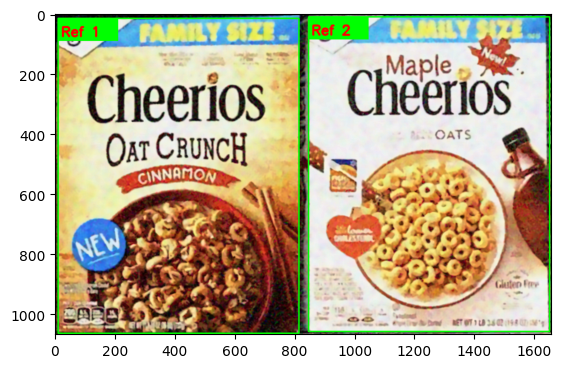


Looking for instances in image 2==================================================


Product 3 - 1 instance found:
	Instance of Ref 3 at Position: (4, 20), width: 606px, height: 948px

Product 4 - 1 instance found:
	Instance of Ref 4 at Position: (610, 7), width: 636px, height: 952px

Product 5 - 1 instance found:
	Instance of Ref 5 at Position: (1247, 28), width: 564px, height: 846px


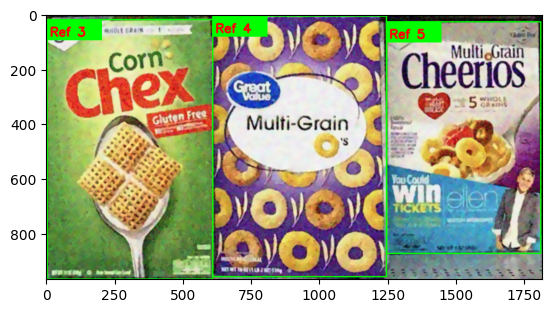


Looking for instances in image 3==================================================


Product 6 - 1 instance found:
	Instance of Ref 6 at Position: (0, 122), width: 604px, height: 668px

Product 7 - 1 instance found:
	Instance of Ref 7 at Position: (618, 135), width: 544px, height: 652px

Product 8 - 1 instance found:
	Instance of Ref 8 at Position: (1168, 6), width: 560px, height: 783px


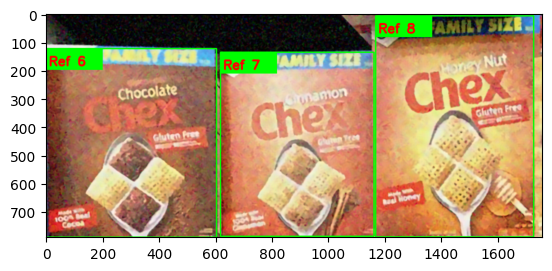


Looking for instances in image 4==================================================


Product 1 - 1 instance found:
	Instance of Ref 1 at Position: (696, 654), width: 382px, height: 517px

Product 8 - 1 instance found:
	Instance of Ref 8 at Position: (174, 12), width: 351px, height: 490px

Product 9 - 1 instance found:
	Instance of Ref 9 at Position: (10, 711), width: 330px, height: 463px

Product 10 - 1 instance found:
	Instance of Ref 10 at Position: (801, 94), width: 275px, height: 406px


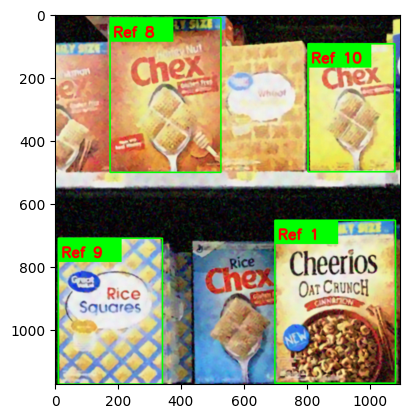


Looking for instances in image 5==================================================


Product 11 - 1 instance found:
	Instance of Ref 11 at Position: (185, 475), width: 369px, height: 557px

Product 12 - 1 instance found:
	Instance of Ref 12 at Position: (496, 407), width: 440px, height: 659px


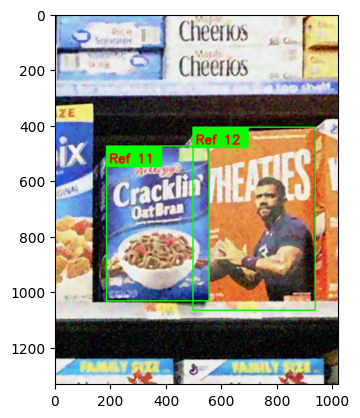

In [ ]:
recognize_instances(images=imgsA, imgs_gray=imgsA_gray, references=refsA, refs_gray=refsA_gray, fix_kp_thresh=9, wind_kp_thresh=5000, fix_temp_thresh=0.25, wind_temp_thresh=1.5)

# Task 2 - Multiple Instance Detection

A good level of accuracy is obtained on the second set of images, despite the presence of some imprecisions which can probably achieved by fine tuning the program, most of the instances are detected and correctly classified.

In regards to each error present we can discuss the reasons behind its presence:


*   Additional Reference 15 in image 6, this is explainable as a consequence of a trade-off in template matching thresholding, as the light-blue colour matches quite closely with the colour of the reference a higher threshold should be deployed to separate the two but such an increase would come at the cost of reducing detectability of more difficult instances in following images.
*  Both References 18 not found in image 9, this error is related to the lack of matches between keypoints of the reference an the image ones, despite the numerous attempts with different filters both on gray-scale and colour-scale, no combination was able to restore enough detail on the image to allow correct matching.
*  Swap between reference 22 and 21 in image 10 is mostly caused by the matching algortithm which, expecially on grayscale, seems to assign more points to reference 22 than 21 as its colour contrast are more appearent in gray-scale.
*  Errors in image 12 are mostly caused by a mixture of problems encountered above, as the instances are extremely similar, expecially in gray-scale, confusion may arise in the matching process. Other than this, image restoration with the chosen filters was not effective enough to restore image details useful to define features, thus leading to some missing instances.



Looking for instances in image 6==================================================


Product 15 - 3 instance found:
	Instance of Ref 15 at Position: (20, 153), width: 360px, height: 848px
	Instance of Ref 15 at Position: (419, 167), width: 329px, height: 905px
	Instance of Ref 15 at Position: (765, 172), width: 342px, height: 842px


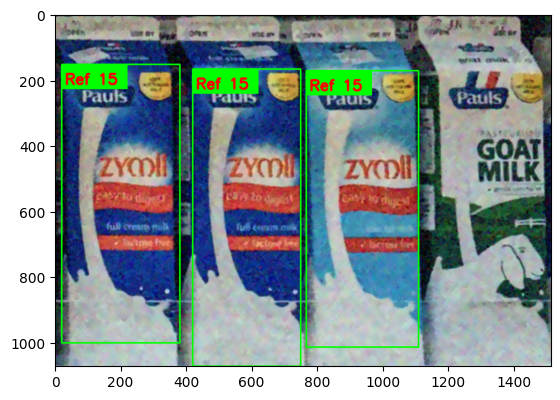


Looking for instances in image 7==================================================


Product 16 - 2 instance found:
	Instance of Ref 16 at Position: (915, 159), width: 231px, height: 604px
	Instance of Ref 16 at Position: (686, 161), width: 218px, height: 604px


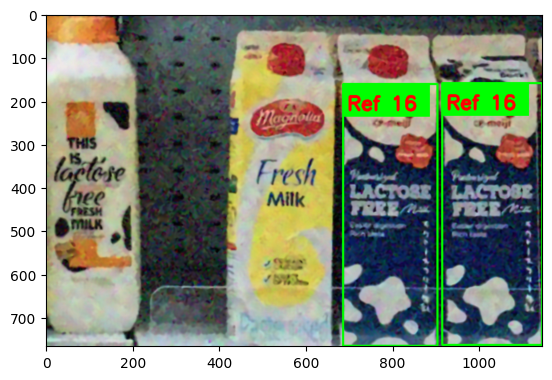


Looking for instances in image 8==================================================


Product 23 - 2 instance found:
	Instance of Ref 23 at Position: (487, 122), width: 321px, height: 882px
	Instance of Ref 23 at Position: (826, 132), width: 324px, height: 874px

Product 24 - 1 instance found:
	Instance of Ref 24 at Position: (1174, 152), width: 329px, height: 855px


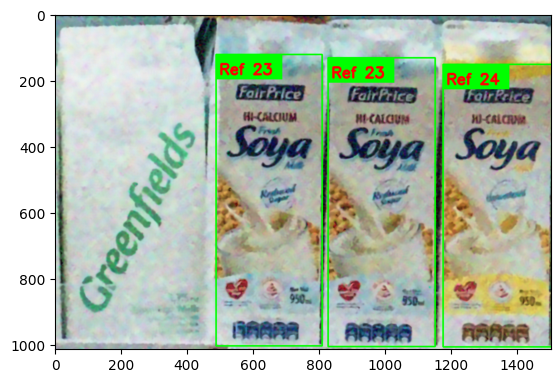


Looking for instances in image 9==================================================


Product 19 - 2 instance found:
	Instance of Ref 19 at Position: (731, 84), width: 232px, height: 575px
	Instance of Ref 19 at Position: (506, 96), width: 229px, height: 559px

Product 20 - 2 instance found:
	Instance of Ref 20 at Position: (985, 94), width: 241px, height: 568px
	Instance of Ref 20 at Position: (1232, 98), width: 244px, height: 564px


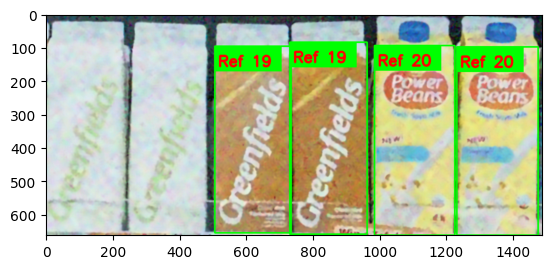


Looking for instances in image 10=================================================


Product 21 - 1 instance found:
	Instance of Ref 21 at Position: (592, 183), width: 246px, height: 721px

Product 22 - 3 instance found:
	Instance of Ref 22 at Position: (1139, 184), width: 245px, height: 706px
	Instance of Ref 22 at Position: (856, 183), width: 255px, height: 701px
	Instance of Ref 22 at Position: (1401, 186), width: 254px, height: 711px


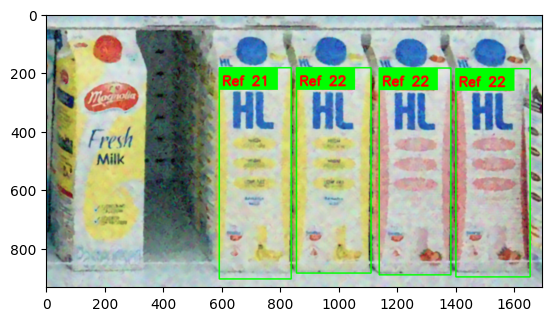


Looking for instances in image 11=================================================


Product 23 - 2 instance found:
	Instance of Ref 23 at Position: (75, 107), width: 185px, height: 503px
	Instance of Ref 23 at Position: (264, 116), width: 187px, height: 490px

Product 24 - 2 instance found:
	Instance of Ref 24 at Position: (650, 133), width: 198px, height: 494px
	Instance of Ref 24 at Position: (463, 121), width: 189px, height: 500px

Product 25 - 3 instance found:
	Instance of Ref 25 at Position: (1248, 132), width: 192px, height: 483px
	Instance of Ref 25 at Position: (1049, 128), width: 190px, height: 484px
	Instance of Ref 25 at Position: (851, 126), width: 191px, height: 496px


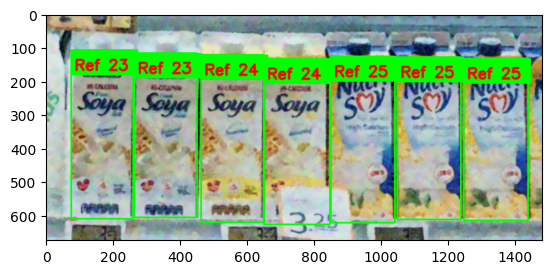


Looking for instances in image 12=================================================


Product 26 - 2 instance found:
	Instance of Ref 26 at Position: (11, 83), width: 248px, height: 597px
	Instance of Ref 26 at Position: (824, 25), width: 269px, height: 644px

Product 27 - 1 instance found:
	Instance of Ref 27 at Position: (283, 103), width: 253px, height: 595px


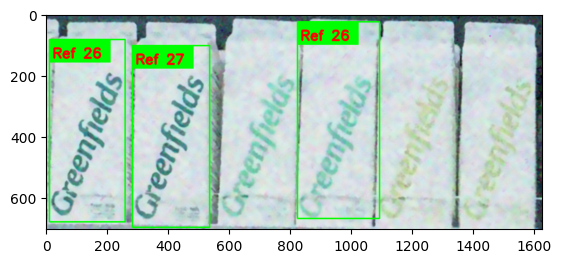

In [ ]:
recognize_instances(images=imgsB, imgs_gray=imgsB_gray, references=refsB, refs_gray=refsB_gray, fix_kp_thresh=9, wind_kp_thresh=3000, fix_temp_thresh=0.3, wind_temp_thresh=0.5, img_shift=5, ref_shift=14)